<a href="https://colab.research.google.com/github/cverluise/PatCit/blob/nightly/notebook/frontpage_normstandard.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
from google.cloud import bigquery
from google.oauth2 import service_account
from google.colab import files


# Set up

> If you don't have the JSON file that contains your key yet, follow the instructions to [create a service account](https://cloud.google.com/docs/authentication/getting-started#creating_a_service_account)

In [ ]:
# Upload your credentials
uploaded = files.upload() 

Saving npl-parsing-3412b4cafd20.json to npl-parsing-3412b4cafd20.json


In [ ]:
key_path = "./npl-parsing-3412b4cafd20.json" # change the name to match your credentials file name

In [ ]:
credentials = service_account.Credentials.from_service_account_file(
    key_path,
    scopes=["https://www.googleapis.com/auth/cloud-platform"],
)

client = bigquery.Client(
    credentials=credentials,
    project=credentials.project_id,
)

In [ ]:
norm_standard_table="patcit-public-data.frontpage.norm_standard"

In [ ]:
FIGSIZE=(12,9)

## Overview

In [ ]:
query = f"""
SELECT
  CAST(cited_by.publication_date/10000 AS INT64) AS publication_year,
  npl_cat_language_flag,
  COUNT(cited_by.publication_number) as nb_cit
FROM
  `{norm_standard_table}`,
  UNNEST(cited_by) AS cited_by
GROUP BY
  publication_year,
  npl_cat_language_flag
ORDER BY
  publication_year DESC
"""

In [ ]:
tmp = client.query(query).to_dataframe()

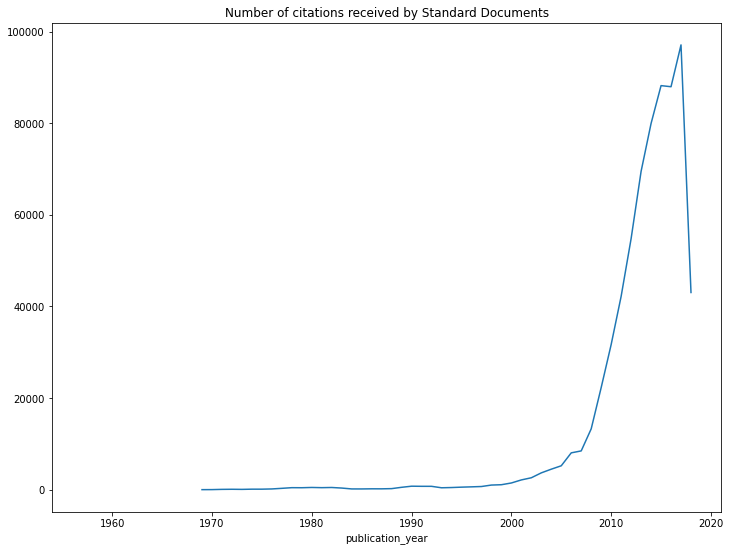

In [ ]:
tmp.pivot(index="publication_year", columns="npl_cat_language_flag", values="nb_cit")[False].plot(title= "Number of citations received by Standard Documents", figsize=FIGSIZE);

## Body

In [ ]:
def get_topn_df(df, var, n=20):
  tmp = df.pivot(index="publication_year", columns=var, values="nb_cit")
  topn = list(tmp.sum().sort_values(ascending=False)[:n].index)
  return tmp[topn]

In [ ]:
query = f"""
  SELECT
    CAST(cited_by.publication_date/10000 AS INT64) AS publication_year,
    body,
    COUNT(body) AS nb_cit
  FROM
    `{norm_standard_table}`,
    UNNEST(cited_by) AS cited_by,
    UNNEST(body) AS body
  GROUP BY
    publication_year,
    body
  ORDER BY
    publication_year DESC,
    nb_cit DESC
"""

In [ ]:
tmp = client.query(query).to_dataframe()

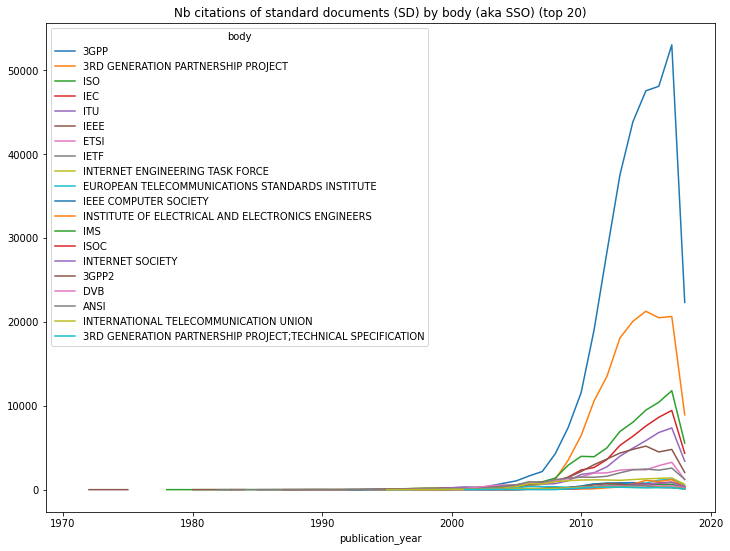

In [ ]:
get_topn_df(tmp, "body").plot(title="Nb citations of standard documents (SD) by body (aka SSO) (top 20)", figsize=FIGSIZE);

## Technology

In [ ]:
query = f"""
  SELECT
    CAST(cited_by.publication_date/10000 AS INT64) AS publication_year,
    tech,
    COUNT(tech) AS nb_cit
  FROM
    `{norm_standard_table}`,
    UNNEST(cited_by) AS cited_by,
    UNNEST(tech) AS tech
  GROUP BY
    publication_year,
    tech
  ORDER BY
    publication_year DESC,
    nb_cit DESC
"""

In [ ]:
tmp = client.query(query).to_dataframe()

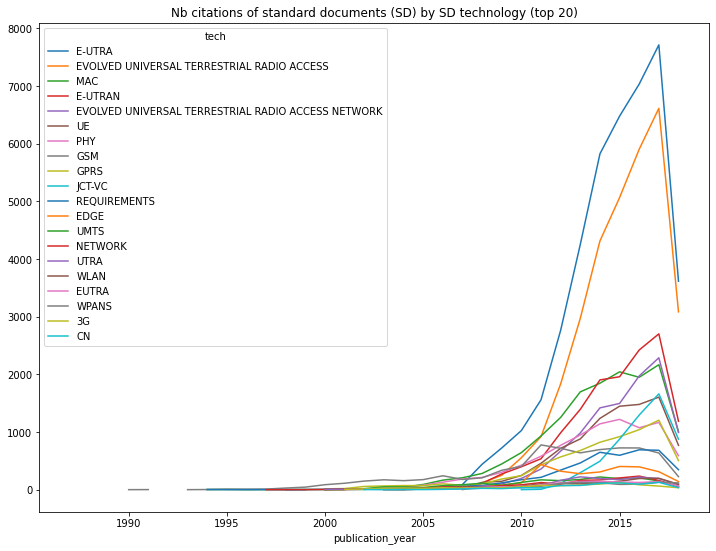

In [ ]:
get_topn_df(tmp, "tech").plot(title="Nb citations of standard documents (SD) by SD technology (top 20)", figsize=FIGSIZE);

## Source

In [ ]:
query = f"""
  SELECT
    CAST(cited_by.publication_date/10000 AS INT64) AS publication_year,
    source,
    COUNT(source) AS nb_cit
  FROM
    `{norm_standard_table}`,
    UNNEST(cited_by) AS cited_by,
    UNNEST(source) AS source
  GROUP BY
    publication_year,
    source
  ORDER BY
    publication_year DESC,
    nb_cit DESC
"""

In [ ]:
tmp = client.query(query).to_dataframe()

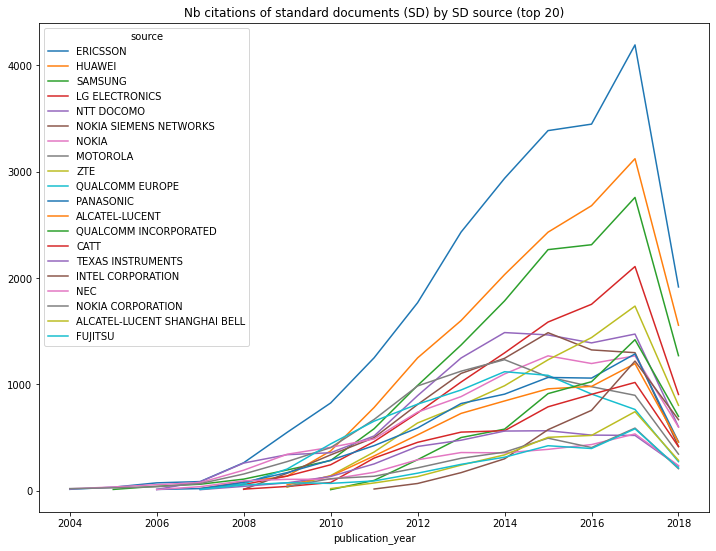

In [ ]:
get_topn_df(tmp, "source").plot(title="Nb citations of standard documents (SD) by SD source (top 20)", figsize=FIGSIZE);

## Citation lag

In [ ]:
query = f"""
SELECT
  CAST(cited_by.publication_date/10000 AS INT64) AS publication_year,
  APPROX_QUANTILES(CAST((cited_by.publication_date - date)/10000 AS INT64),10) AS lag
FROM
  `{norm_standard_table}`,
  UNNEST(cited_by) AS cited_by,
  UNNEST(date) AS date
WHERE
  npl_cat_language_flag is False
GROUP BY
  publication_year
ORDER BY
  publication_year DESC"""

In [ ]:
tmp = client.query(query).to_dataframe()

In [ ]:
tmp_ = tmp.copy()
for i in range(10):
    if i ==0:
      pass
    else:
      tmp_[f"lag_{i}"] = tmp["lag"].apply(lambda l: l[i])
tmp_ = tmp_.sort_values("publication_year", ascending=True)

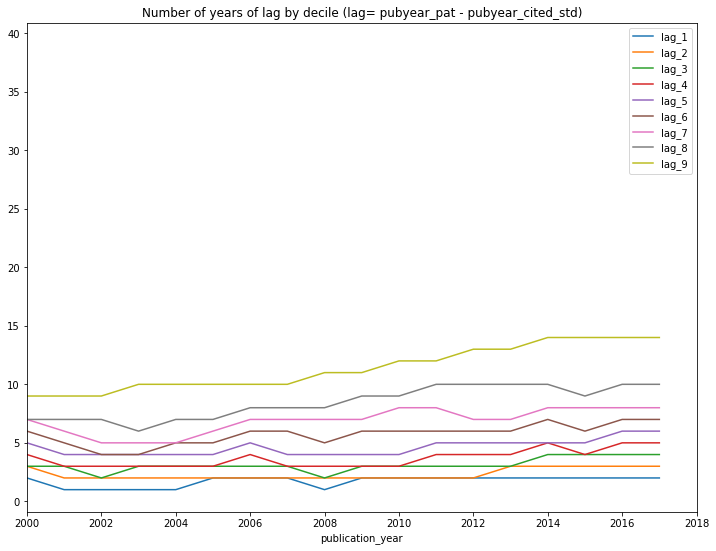

In [ ]:
(tmp_
 .query("1980<publication_year<2018")
 .set_index("publication_year")
 .filter(regex="lag_")
 .plot(figsize=FIGSIZE, title="Number of years of lag by decile (lag= pubyear_pat - pubyear_cited_std)", xlim=(2000, 2018)));

## Country code

In [ ]:
query = f"""
SELECT
  CAST(cited_by.publication_date/10000 AS INT64) AS publication_year,
  SPLIT(cited_by.publication_number, "-")[
OFFSET
  (0)] AS country_code,
  COUNT(cited_by.publication_number) AS nb_cit
FROM
  `{norm_standard_table}`,
  UNNEST(cited_by) AS cited_by
WHERE
  npl_cat_language_flag IS FALSE
GROUP BY
  publication_year,
  country_code"""

In [ ]:
tmp = client.query(query).to_dataframe()

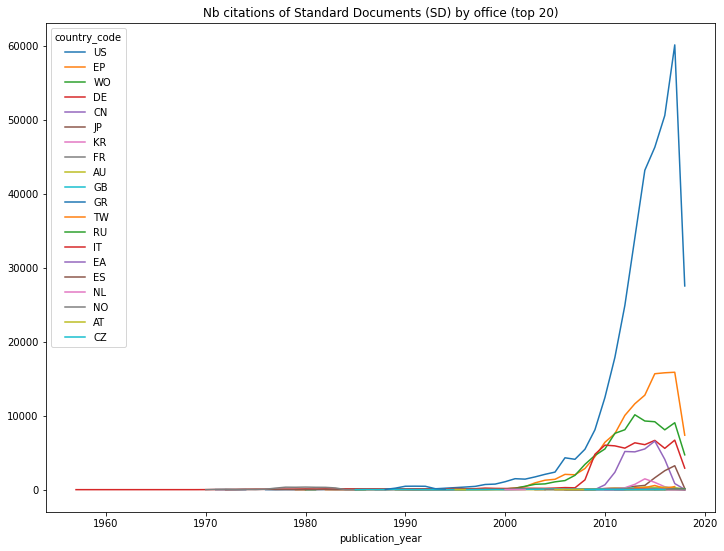

In [ ]:
get_topn_df(tmp, "country_code", 20).plot(title="Nb citations of Standard Documents (SD) by office (top 20)", figsize=FIGSIZE);
